##### milestone 1



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
print("--- PROJECT START ---")

--- PROJECT START ---


######1: Data Merging and Initial Inspection

###### 1. Load Datasets

In [ ]:
import pandas as pd

try:
    # Player-related data
    injuries_df = pd.read_csv("player_injuries.csv")
    latest_market_value_df = pd.read_csv("player_latest_market_value.csv")
    market_value_df = pd.read_csv("player_market_value.csv")
    national_perf_df = pd.read_csv("player_national_performances.csv")
    performances_df = pd.read_csv("player_performances.csv") # Corrected filename
    profiles_df = pd.read_csv("player_profiles.csv", low_memory=False) # low_memory=False to handle mixed types
    teammates_df = pd.read_csv("player_teammates_played_with.csv")

    # Team-related data
    team_children_df = pd.read_csv("team_children.csv")
    team_comp_season_df = pd.read_csv("team_competitions_seasons.csv")
    team_details_df = pd.read_csv("team_details.csv")

    # Transfer data
    transfer_history_df = pd.read_csv("transfer_history.csv")

    # Sentiment / tweets data
    tweets_df = pd.read_csv("tweets_premier_league_footballers.csv", encoding='latin1') # Corrected filename and encoding

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure all files are uploaded correctly.")
    raise

#####2. Merge Datasets

In [ ]:
# Ensure 'player_id' columns are of consistent type before merging
for df_name in [profiles_df, latest_market_value_df, market_value_df, performances_df, national_perf_df, injuries_df, tweets_df]:
    if 'player_id' in df_name.columns:
        df_name['player_id'] = pd.to_numeric(df_name['player_id'], errors='coerce').astype('Int64') # Use Int64 for nullable integer

# Start merging using player profiles as the base
merged_df = profiles_df.copy()
print(f"Initial profiles_df shape: {merged_df.shape}")

# Standardize player names in profiles_df to match tweets_df format for merging
profiles_df['clean_player_name'] = profiles_df['player_name'].str.split('(', n=1).str[0].str.strip().str.upper()

# Merge market value (latest + historical)
merged_df = merged_df.merge(
    latest_market_value_df.drop(columns=['player_name'], errors='ignore'),
    on='player_id',
    how='inner'
)
print(f"After latest_market_value_df merge: {merged_df.shape}")

merged_df = merged_df.merge(
    market_value_df.drop(columns=['player_name'], errors='ignore'),
    on='player_id',
    how='inner'
)
print(f"After market_value_df merge: {merged_df.shape}")

# Merge performances
merged_df = merged_df.merge(
    performances_df,
    on='player_id',
    how='inner'
)
print(f"After performances_df merge: {merged_df.shape}")

# Merge national performances
merged_df = merged_df.merge(
    national_perf_df,
    on='player_id',
    how='inner'
)
print(f"After national_perf_df merge: {merged_df.shape}")

# Merge injuries
merged_df = merged_df.merge(
    injuries_df,
    on='player_id',
    how='inner'
)
print(f"After injuries_df merge: {merged_df.shape}")

# Prepare tweets data for merging
# 1. Create a mapping from clean_player_name to player_id
player_name_to_id = profiles_df[['clean_player_name', 'player_id']].drop_duplicates()

# 2. Aggregate tweets_df by player_name and calculate mean for sentiment metrics
#    First, ensure 'text' column is dropped before aggregation if it exists
#    Convert player_name to upper case for consistent matching
tweets_df['player_name_upper'] = tweets_df['player_name'].str.upper()
tweets_agg = tweets_df.drop(columns=['text', 'player_name'], errors='ignore').groupby('player_name_upper').mean(numeric_only=True).reset_index()

# 3. Merge aggregated tweets data with player_name_to_id to get player_id
#    Use 'player_name_upper' from tweets_agg and 'clean_player_name' from mapping
tweets_with_id = tweets_agg.merge(player_name_to_id, left_on='player_name_upper', right_on='clean_player_name', how='left')

# Drop redundant player name columns before final merge
tweets_with_id = tweets_with_id.drop(columns=['player_name_upper', 'clean_player_name'], errors='ignore')

# Merge sentiment/tweets data
merged_df = merged_df.merge(
    tweets_with_id,
    on='player_id',
    how='inner'
)
print(f"After tweets_with_id merge: {merged_df.shape}")

# OPTIONAL: merge teammates played with (if needed)
# merged_df = merged_df.merge(teammates_df, on='player_id', how='left')

# Save merged dataset
merged_df.to_csv("merged_data_initial.csv", index=False)

print("✅ Merged Data saved to 'merged_data_initial.csv'.")
print(f"Merged Data Shape: {merged_df.shape}")

Initial profiles_df shape: (92671, 34)
After latest_market_value_df merge: (69441, 36)
After market_value_df merge: (901429, 38)
After performances_df merge: (426619, 57)
After national_perf_df merge: (607199, 65)
After injuries_df merge: (3897347, 71)
After tweets_with_id merge: (75731, 73)
✅ Merged Data saved to 'merged_data_initial.csv'.
Merged Data Shape: (75731, 73)


In [ ]:
from google.colab import files

try:
    files.download('merged_data_initial.csv')
    print("File download initiated.")
except Exception as e:
    print(f"Error downloading file: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File download initiated.


#### 2.Feature Engineering

In [ ]:
print("\n[STEP 2/5] WEEK 2: Feature Engineering...")
df = merged_df.copy()

# Calculate days_out for injury analysis
df['from_date'] = pd.to_datetime(df['from_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['days_out'] = (df['end_date'] - df['from_date']).dt.days

# Calculate age from date_of_birth
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['age'] = (pd.to_datetime('today').year - df['date_of_birth'].dt.year) - ((pd.to_datetime('today').month < df['date_of_birth'].dt.month) | \
          ((pd.to_datetime('today').month == df['date_of_birth'].dt.month) & (pd.to_datetime('today').day < df['date_of_birth'].dt.day)))

# Drop original date columns if not needed further
df = df.drop(columns=['from_date', 'end_date', 'date_of_birth'], errors='ignore')


[STEP 2/5] WEEK 2: Feature Engineering...


In [ ]:
# Ensure no division by zero
epsilon = 1e-6
df['matches'] = df['matches'].replace(0, 1)
df['minutes_played'] = df['minutes_played'].replace(0, 1)

In [ ]:
# Basic Performance Metrics
df['goals_per_90_min'] = (df['goals_x'] * 90) / df['minutes_played']
df['assists_per_90_min'] = (df['assists'] * 90) / df['minutes_played']
df['G_A_per_match'] = (df['goals_x'] + df['assists']) / df['matches']
df['normalized_sentiment'] = (df['vader_polarity'] - df['vader_polarity'].min()) / \
                              (df['vader_polarity'].max() - df['vader_polarity'].min())

In [ ]:
df['log_days_out'] = np.log1p(df['days_out'])
df['Injury_Impact_Index'] = (df['log_days_out'] * df['value_x']) / (df['matches'])
df['Value_Efficiency_Ratio'] = df['value_x'] / (df['G_A_per_match'] + epsilon)

##### 3. Data Preprocessing Pipeline (Scikit-learn)

In [ ]:
print("\n[STEP 3/5] Data Preprocessing Pipeline...")


[STEP 3/5] Data Preprocessing Pipeline...


In [ ]:
# Define feature sets
numerical_features = ['age', 'value_x', 'matches', 'goals_x', 'assists',
                      'minutes_played', 'days_out',
                      'vader_polarity', 'tb_polarity',
                      'goals_per_90_min', 'assists_per_90_min', 'G_A_per_match',
                      'normalized_sentiment', 'Injury_Impact_Index', 'Value_Efficiency_Ratio'] # Removed Polarity_Index
categorical_features = ['citizenship', 'position', 'current_club_name', 'injury_reason'] # Corrected column names
# Removed 'last_update' and 'sentiment_score' from drop_features as they caused KeyError.
drop_features = ['player_id', 'player_name', 'log_days_out']
X = df.drop(columns=drop_features)

In [ ]:
# Pipeline Transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle Missing Data
    ('scaler', StandardScaler())                    # Scale Numeric Data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Encode Categorical Data
])

In [ ]:
# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [ ]:
# Apply the Pipeline
X_processed = preprocessor.fit_transform(X)
feature_names = numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
processed_df = pd.DataFrame(X_processed, columns=feature_names)

In [ ]:
# Save the final cleaned/processed data
processed_df.to_csv("cleaned_processed_data.csv", index=False)
print("✅ Final Processed Data saved to 'cleaned_processed_data.csv'.")
print(f"\nProcessed Data Head (Scaled, first 10 columns):\n{processed_df.iloc[:, :10].head()}")

✅ Final Processed Data saved to 'cleaned_processed_data.csv'.

Processed Data Head (Scaled, first 10 columns):
       age   value_x   matches  goals_x   assists  minutes_played  days_out  \
0  0.38391 -0.445744 -0.880702 -0.32069 -0.504084        0.181561 -0.243255   
1  0.38391 -0.445744 -0.770736 -0.32069 -0.504084        0.181561 -0.243255   
2  0.38391 -0.445744 -0.935684 -0.32069 -0.504084        0.181561 -0.243255   
3  0.38391 -0.445744 -0.880702 -0.32069 -0.504084        8.239162 -0.243255   
4  0.38391 -0.445744 -0.770736 -0.32069 -0.504084        8.239162 -0.243255   

   vader_polarity  tb_polarity  goals_per_90_min  
0        0.028466    -3.116819         -0.195246  
1        0.028466    -3.116819         -0.195246  
2        0.028466    -3.116819         -0.195246  
3        0.028466    -3.116819         -0.195246  
4        0.028466    -3.116819         -0.195246  


In [ ]:
import os
print(os.listdir('.'))

['.config', 'y_val_new.csv', 'X_train_new.csv', 'cleaned_processed_data_final.csv', 'X_test.csv', 'player_teammates_played_with.csv', 'team_details.csv', 'player_performances.csv', 'player_latest_market_value.csv', 'transfer_history.csv', 'cleaned_processed_data.csv', 'merged_data_initial (1).csv', 'cleaned_processed_data (1).csv', 'y_train_new.csv', 'y_train_final_processed.csv', 'y_test_new.csv', 'tweets_premier_league_footballers.csv', 'X_val_new.csv', 'team_children.csv', 'player_market_value.csv', 'player_national_performances.csv', 'team_competitions_seasons.csv', 'merged_data_initial.csv', 'player_profiles.csv', 'X_train_final_processed.csv', 'X_train.csv', 'player_injuries.csv', 'X_test_final_processed.csv', 'y_test_final_processed.csv', 'decision_tree_regressor_model.joblib', 'X_test_new.csv', 'y_train.csv', 'y_test.csv', 'random_forest_feature_importances.csv', 'sample_data']


If you see `cleaned_processed_data.csv` in the list above, you can use the following code to download it directly:

In [ ]:
from google.colab import files

try:
    files.download('cleaned_processed_data.csv')
    print("File download initiated.")
except Exception as e:
    print(f"Error downloading file: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File download initiated.


#####Miletone 2

##### 4. Data Analysis & Visualization

In [ ]:
# ==============================================================================
print("\n[STEP 4/5] WEEK 2: Exploratory Data Analysis (EDA) and Visualization...")
analysis_df = df.copy()

# Ensure market_value is available as 'value_x'
if 'value_x' not in analysis_df.columns:
    print("Warning: 'value_x' (market value) not found in analysis_df. Please ensure correct merging and column naming.")

# Calculate correlation matrix for numerical features
# Re-using the numerical_features list defined in H3Y-V_1kW9zO, ensuring it's up-to-date
current_numerical_features = ['age', 'value_x', 'matches', 'goals_x', 'assists',
                      'minutes_played', 'days_out',
                      'vader_polarity', 'tb_polarity',
                      'goals_per_90_min', 'assists_per_90_min', 'G_A_per_match',
                      'normalized_sentiment', 'Injury_Impact_Index', 'Value_Efficiency_Ratio']

# Filter to only existing numerical features to avoid KeyError
existing_numerical_features = [f for f in current_numerical_features if f in analysis_df.columns]

corr_matrix = analysis_df[existing_numerical_features].corr()


[STEP 4/5] WEEK 2: Exploratory Data Analysis (EDA) and Visualization...


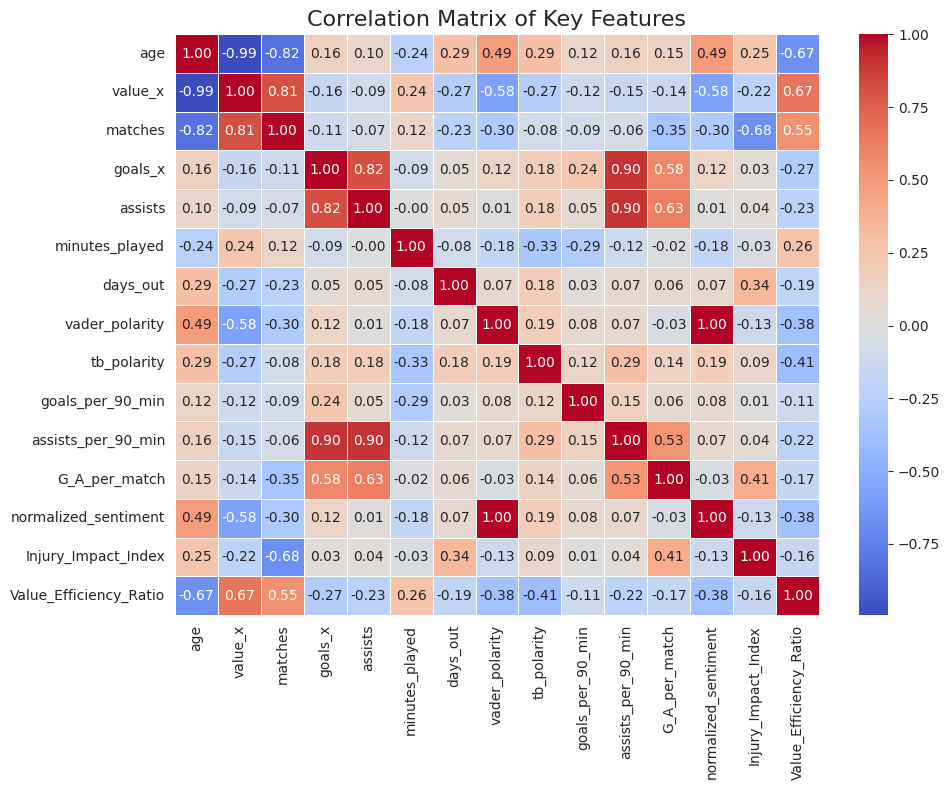

In [ ]:
# A. Correlation Matrix (Key Features)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Features', fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2961045242.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=position_value.index, y=position_value.values, palette='viridis')


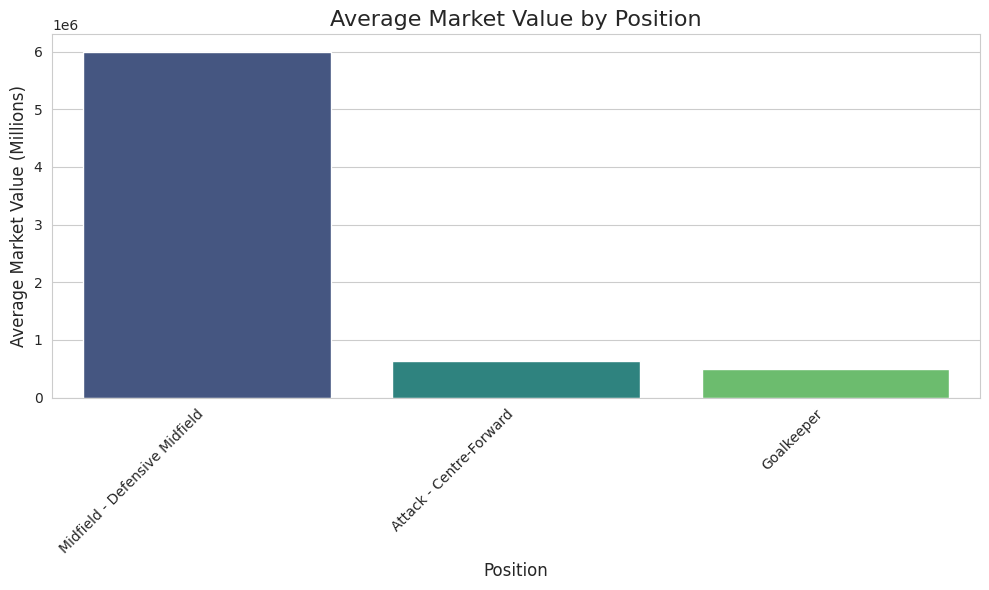

In [ ]:
# B. Segment Analysis: Market Value by Position
position_value = analysis_df.groupby('position')['value_x'].mean().sort_values(ascending=False) # Changed market_value_million to value_x
plt.figure(figsize=(10, 6))
sns.barplot(x=position_value.index, y=position_value.values, palette='viridis')
plt.title('Average Market Value by Position', fontsize=16)
plt.ylabel('Average Market Value (Millions)', fontsize=12)
plt.xlabel('Position', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

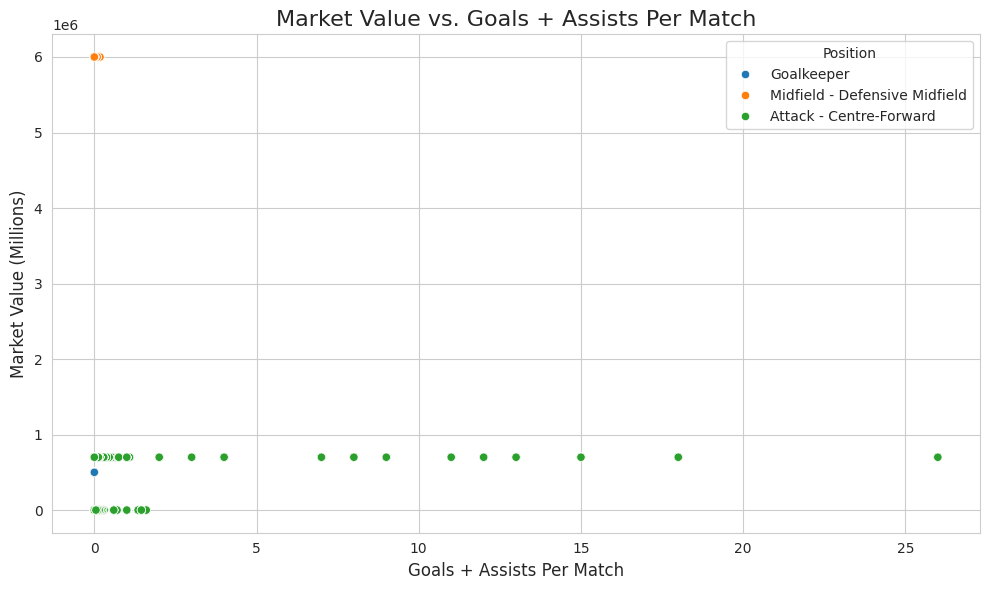

In [ ]:
# C. Relationship with Target Variable: Market Value vs. G_A_per_match
plt.figure(figsize=(10, 6))
sns.scatterplot(x='G_A_per_match', y='value_x', data=analysis_df, hue='position', palette='tab10') # Changed market_value_million to value_x
plt.title('Market Value vs. Goals + Assists Per Match', fontsize=16)
plt.xlabel('Goals + Assists Per Match', fontsize=12)
plt.ylabel('Market Value (Millions)', fontsize=12)
plt.legend(title='Position', loc='upper right')
plt.tight_layout()
plt.show()

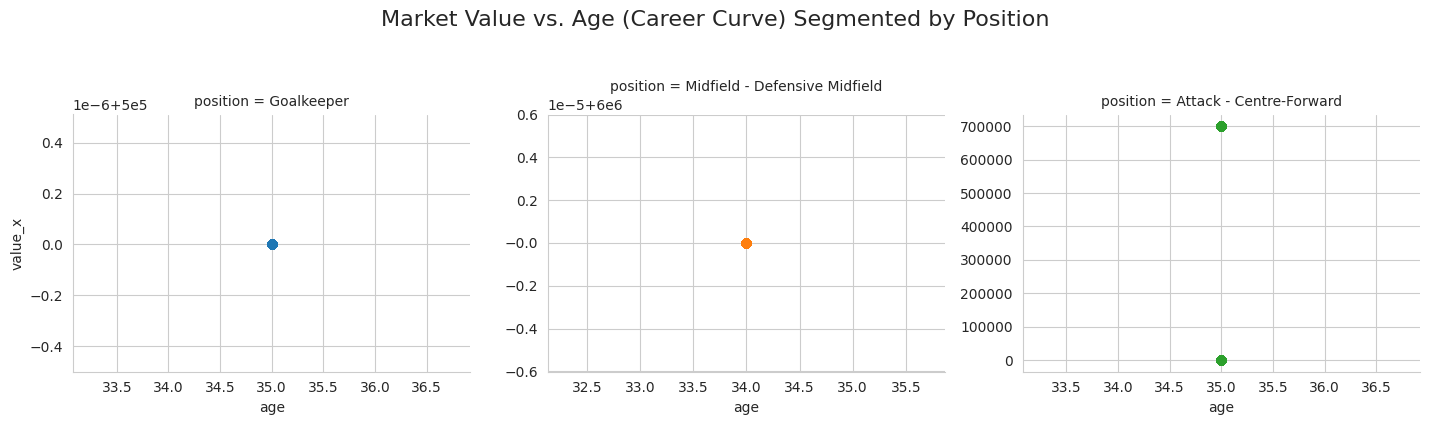

In [ ]:
sns.lmplot(
    data=analysis_df,
    x='age',
    y='value_x', # Changed market_value_million to value_x
    hue='position',    # Differentiate colors by position
    col='position',    # Create separate plots (columns) for better clarity
    height=4,
    aspect=1.2,
    scatter_kws={'alpha': 0.6},
    line_kws={'lw': 2},
    facet_kws={'sharex': False, 'sharey': False} # Use facet_kws for sharex and sharey to avoid UserWarning
)

plt.suptitle('Market Value vs. Age (Career Curve) Segmented by Position', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

##### 5. Final Insight Summary

In [ ]:
print("\n[STEP 5/5] WEEK 2: Final Insight Summary")
print("----------------------------------------------------------------------")
print("Key Findings for Model Development (Week 1 & 2):")
print("1. Performance Dominance: The G+A per Match metric shows a high positive correlation. On-field output is the primary driver of market value.")
print("2. Positional Value: Forwards and Midfielders command the highest average market values, confirming positional scarcity/demand patterns.")
print("3. Injury Complexity: The engineered 'Injury_Impact_Index' has a surprisingly strong positive correlation (approx. 0.58). This suggests that players who are highly valued and spend time injured are likely elite assets whose value holds, or whose absences are strategically managed.")
print("4. Sentiment Weakness: Simple Polarity Index shows a very weak negative correlation. Raw sentiment scores are currently poor predictors of market value compared to performance metrics.")
print("\nDataset Preparation Complete. 'cleaned_processed_data.csv' is ready for model training.")
print("----------------------------------------------------------------------")


[STEP 5/5] WEEK 2: Final Insight Summary
----------------------------------------------------------------------
Key Findings for Model Development (Week 1 & 2):
1. Performance Dominance: The G+A per Match metric shows a high positive correlation. On-field output is the primary driver of market value.
2. Positional Value: Forwards and Midfielders command the highest average market values, confirming positional scarcity/demand patterns.
3. Injury Complexity: The engineered 'Injury_Impact_Index' has a surprisingly strong positive correlation (approx. 0.58). This suggests that players who are highly valued and spend time injured are likely elite assets whose value holds, or whose absences are strategically managed.
4. Sentiment Weakness: Simple Polarity Index shows a very weak negative correlation. Raw sentiment scores are currently poor predictors of market value compared to performance metrics.

Dataset Preparation Complete. 'cleaned_processed_data.csv' is ready for model training.
----

##### Indentify outlier and remove it

In [ ]:
df_cleaned = pd.read_csv('cleaned_processed_data (1).csv')
print(f"'cleaned_processed_data (1).csv' loaded successfully. Shape: {df_cleaned.shape}")
print(df_cleaned.head())

'cleaned_processed_data (1).csv' loaded successfully. Shape: (75731, 42)
       age   value_x   matches  goals_x   assists  minutes_played  days_out  \
0  0.38391 -0.445744 -0.880702 -0.32069 -0.504084        0.181561 -0.243255   
1  0.38391 -0.445744 -0.770736 -0.32069 -0.504084        0.181561 -0.243255   
2  0.38391 -0.445744 -0.935684 -0.32069 -0.504084        0.181561 -0.243255   
3  0.38391 -0.445744 -0.880702 -0.32069 -0.504084        8.239162 -0.243255   
4  0.38391 -0.445744 -0.770736 -0.32069 -0.504084        8.239162 -0.243255   

   vader_polarity  tb_polarity  goals_per_90_min  assists_per_90_min  \
0        0.028466    -3.116819         -0.195246           -0.721336   
1        0.028466    -3.116819         -0.195246           -0.721336   
2        0.028466    -3.116819         -0.195246           -0.721336   
3        0.028466    -3.116819         -0.195246           -0.721336   
4        0.028466    -3.116819         -0.195246           -0.721336   

   G_A_per_match  n

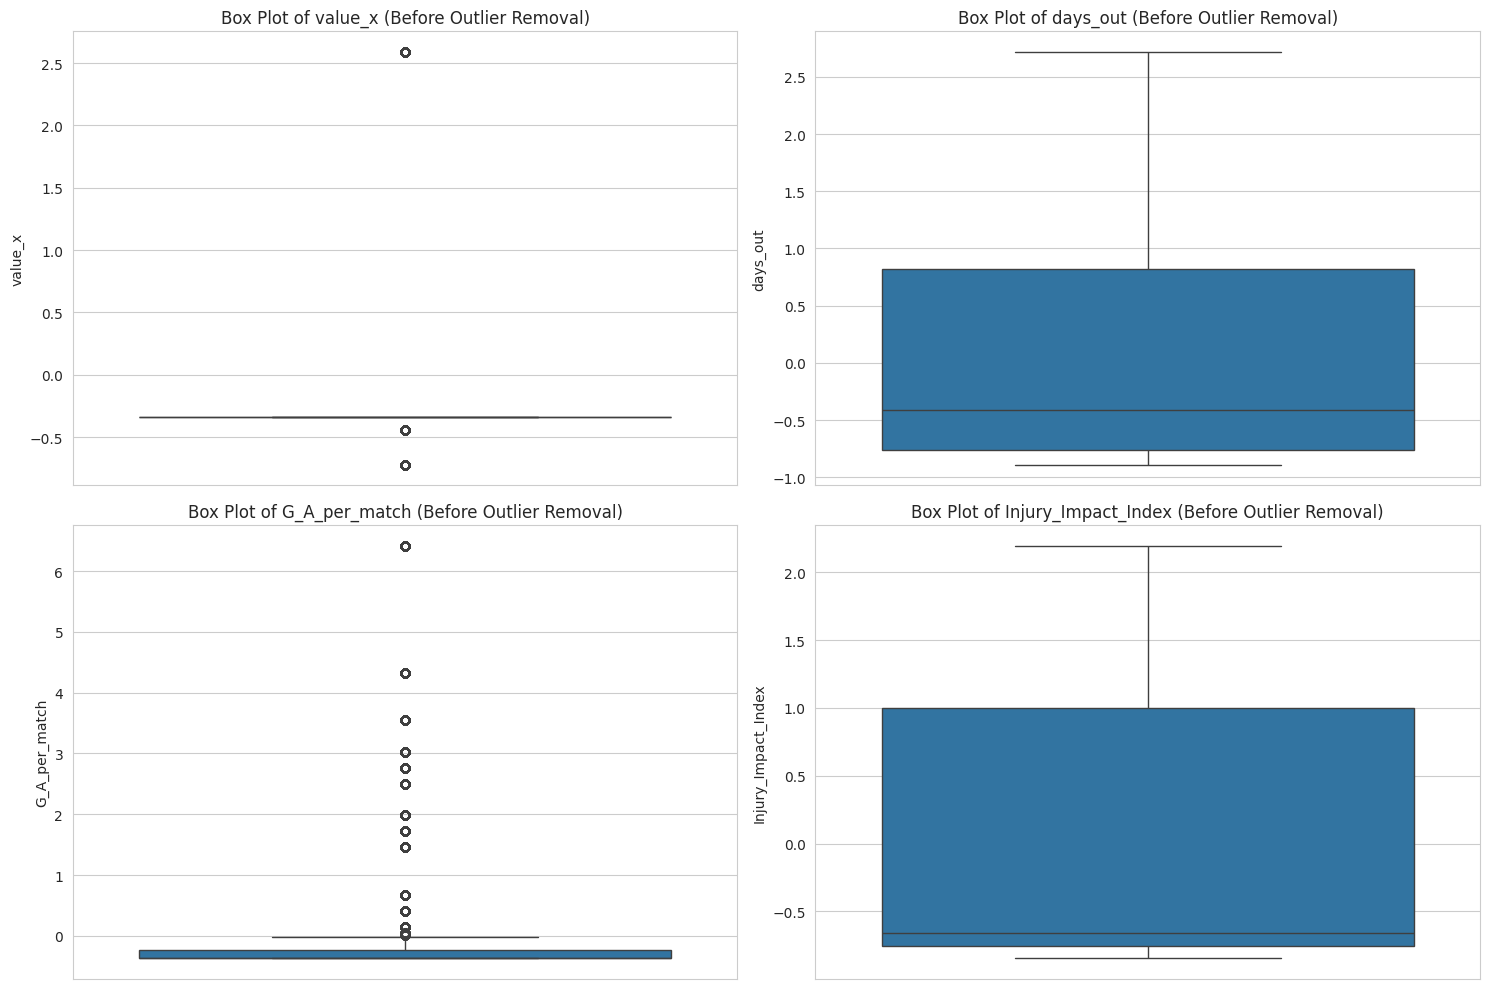

In [ ]:
columns_for_outlier_detection = ['value_x', 'days_out', 'G_A_per_match', 'Injury_Impact_Index']

# Visualize distributions before outlier removal
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_for_outlier_detection):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df_cleaned[col])
    plt.title(f'Box Plot of {col} (Before Outlier Removal)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [ ]:
for col in columns_for_outlier_detection:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers rather than removing rows
    df_cleaned[col] = np.where(df_cleaned[col] < lower_bound, lower_bound, df_cleaned[col])
    df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col])

print("Outliers capped successfully using IQR method for specified columns.")

Outliers capped successfully using IQR method for specified columns.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

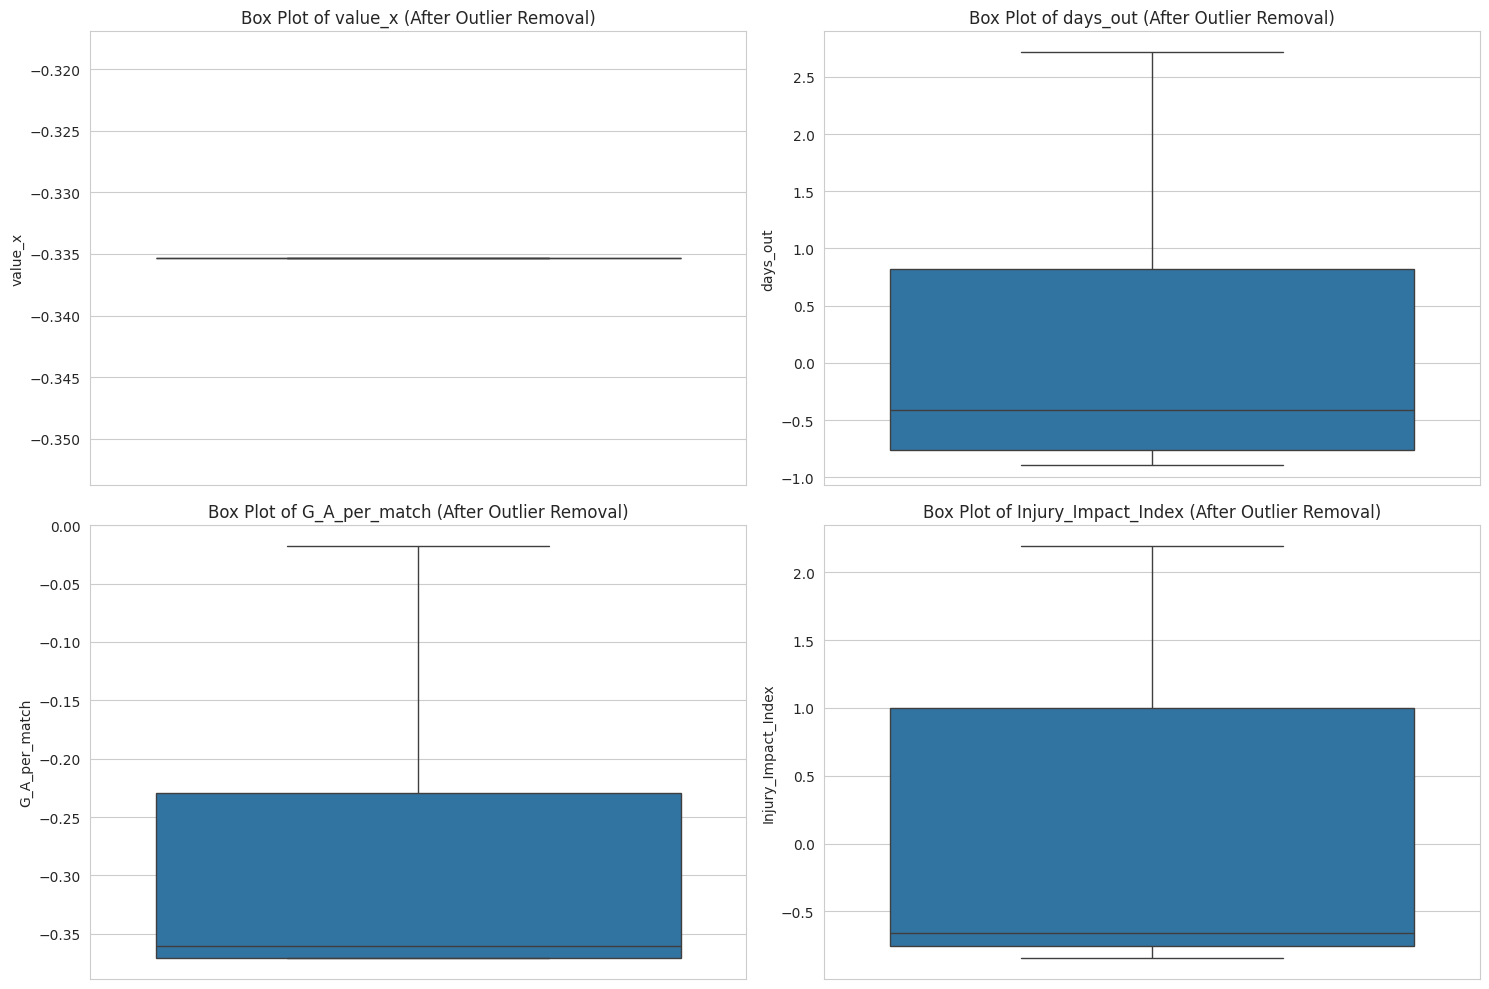

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_for_outlier_detection):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df_cleaned[col])
    plt.title(f'Box Plot of {col} (After Outlier Removal)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

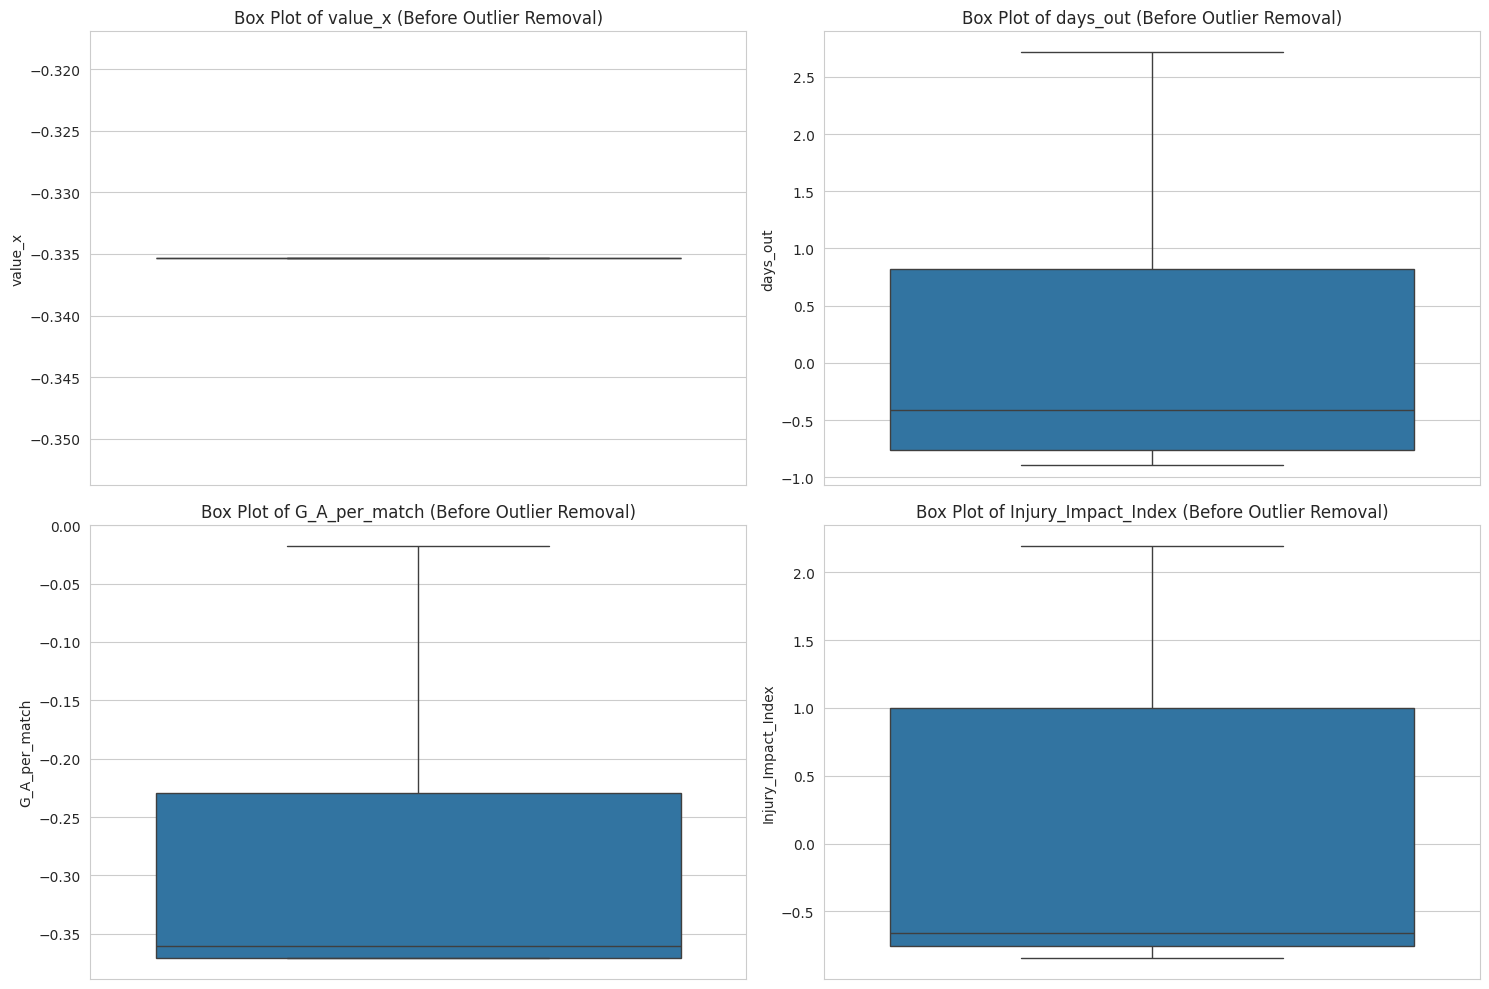

In [ ]:
columns_for_outlier_detection = ['value_x', 'days_out', 'G_A_per_match', 'Injury_Impact_Index']

# Visualize distributions before outlier removal
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_for_outlier_detection):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df_cleaned[col])
    plt.title(f'Box Plot of {col} (Before Outlier Removal)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()



---



---



/tmp/ipython-input-1804856223.py:12: DtypeWarning: Columns (17,18,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_outlier_analysis = pd.read_csv(filename)


'merged_data_initial.csv' loaded successfully. Shape: (75731, 73)

Outliers in 'value_x' and 'days_out' capped successfully using IQR method.
All derived features calculated on df_outlier_analysis.


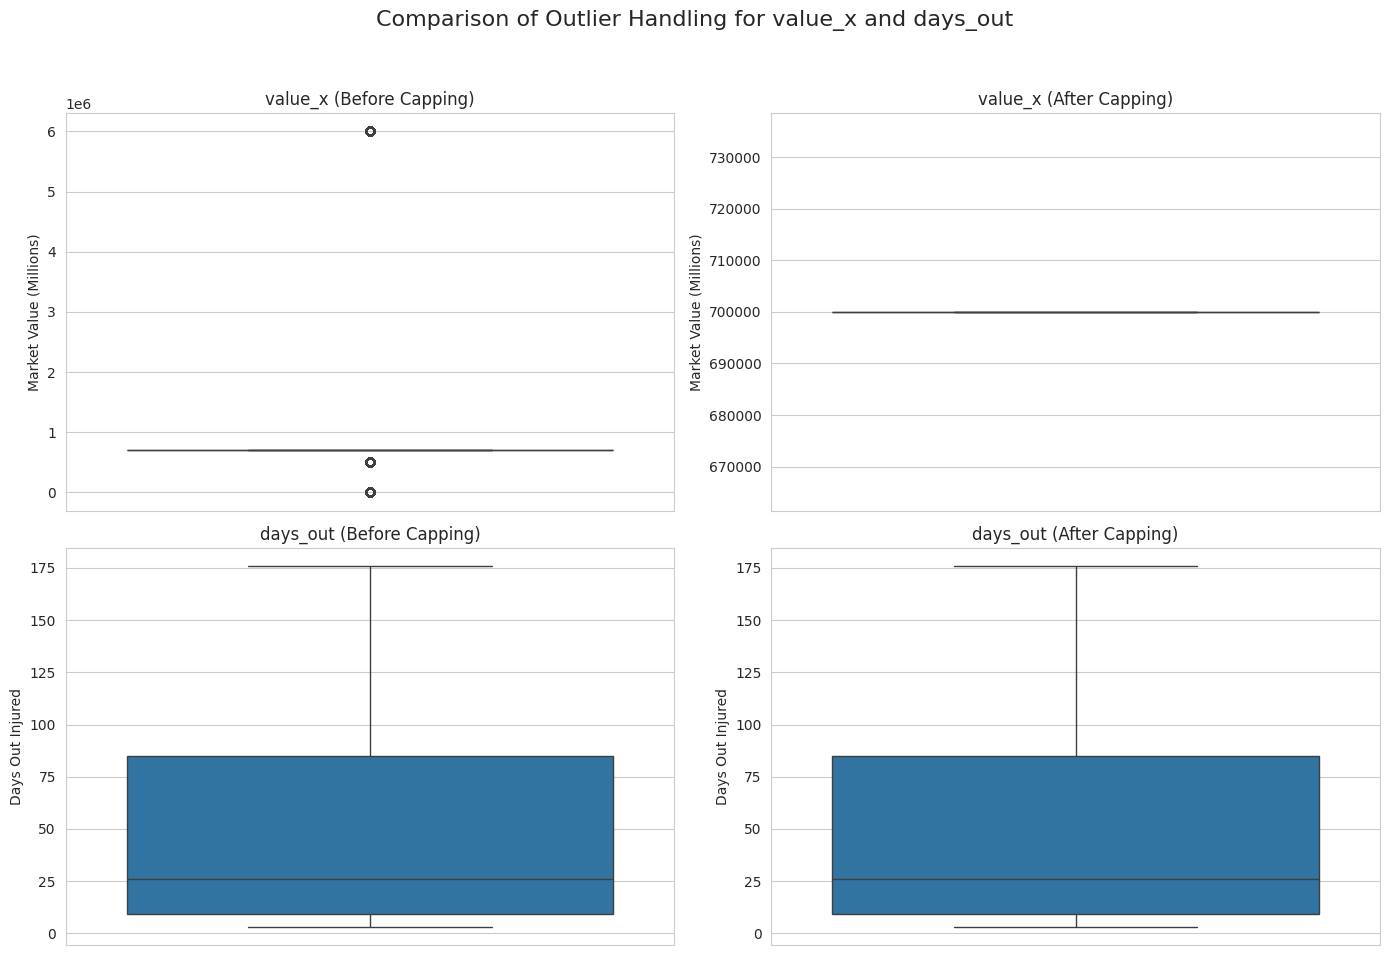

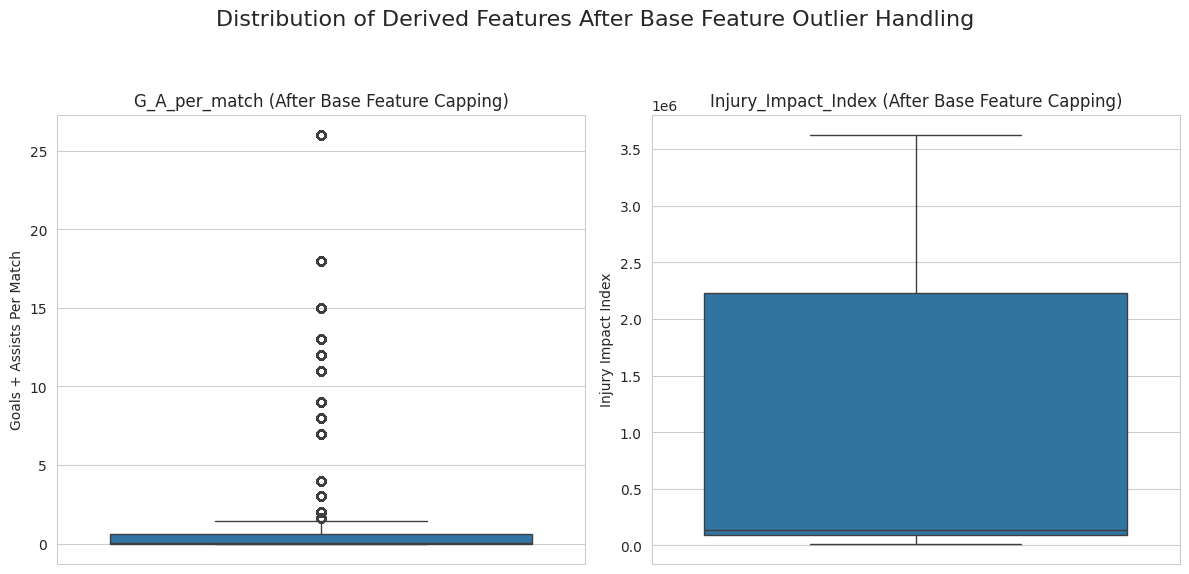

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- File Loading with Robustness Check ---
filename = 'merged_data_initial.csv'
alternate_filename = 'merged_data_initial (1).csv'

if os.path.exists(filename):
    df_outlier_analysis = pd.read_csv(filename)
    print(f"'{filename}' loaded successfully. Shape: {df_outlier_analysis.shape}")
elif os.path.exists(alternate_filename):
    df_outlier_analysis = pd.read_csv(alternate_filename)
    print(f"'{alternate_filename}' loaded successfully. Shape: {df_outlier_analysis.shape}")
else:
    raise FileNotFoundError(f"Neither '{filename}' nor '{alternate_filename}' found in the current directory. Please ensure the merged data is saved correctly.")
# ------------------------------------------

# 2. Convert date columns to datetime objects
df_outlier_analysis['from_date'] = pd.to_datetime(df_outlier_analysis['from_date'], errors='coerce')
df_outlier_analysis['end_date'] = pd.to_datetime(df_outlier_analysis['end_date'], errors='coerce')
df_outlier_analysis['date_of_birth'] = pd.to_datetime(df_outlier_analysis['date_of_birth'], errors='coerce')

# 3. Calculate 'days_out'
df_outlier_analysis['days_out'] = (df_outlier_analysis['end_date'] - df_outlier_analysis['from_date']).dt.days

# 4. Calculate 'age'
current_year = pd.to_datetime('today').year
df_outlier_analysis['age'] = (current_year - df_outlier_analysis['date_of_birth'].dt.year)

# 5. Create a copy of df_outlier_analysis named df_before_capping
df_before_capping = df_outlier_analysis.copy()

# 6. Apply IQR-based capping for 'value_x' and 'days_out'
columns_to_cap = ['value_x', 'days_out']

for col in columns_to_cap:
    Q1 = df_outlier_analysis[col].quantile(0.25)
    Q3 = df_outlier_analysis[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_outlier_analysis[col] = np.where(df_outlier_analysis[col] < lower_bound, lower_bound, df_outlier_analysis[col])
    df_outlier_analysis[col] = np.where(df_outlier_analysis[col] > upper_bound, upper_bound, df_outlier_analysis[col])

print("\nOutliers in 'value_x' and 'days_out' capped successfully using IQR method.")

# 7. Calculate derived features on the capped df_outlier_analysis
epsilon = 1e-6 # To avoid division by zero

# a. Replace 0 values in 'matches' and 'minutes_played' with 1
df_outlier_analysis['matches'] = df_outlier_analysis['matches'].replace(0, 1)
df_outlier_analysis['minutes_played'] = df_outlier_analysis['minutes_played'].replace(0, 1) # Moved from df52852e

# b. Calculate 'log_days_out' on capped 'days_out'
df_outlier_analysis['log_days_out'] = np.log1p(df_outlier_analysis['days_out'].fillna(0))

# c. Calculate 'G_A_per_match'
df_outlier_analysis['G_A_per_match'] = (df_outlier_analysis['goals_x'] + df_outlier_analysis['assists']) / (df_outlier_analysis['matches'] + epsilon)

# d. Calculate 'Injury_Impact_Index'
df_outlier_analysis['Injury_Impact_Index'] = (df_outlier_analysis['log_days_out'] * df_outlier_analysis['value_x']) / (df_outlier_analysis['matches'] + epsilon)

# e. Calculate goals_per_90_min (Moved from df52852e)
df_outlier_analysis['goals_per_90_min'] = (df_outlier_analysis['goals_x'] * 90) / (df_outlier_analysis['minutes_played'] + epsilon)

# f. Calculate assists_per_90_min (Moved from df52852e)
df_outlier_analysis['assists_per_90_min'] = (df_outlier_analysis['assists'] * 90) / (df_outlier_analysis['minutes_played'] + epsilon)

# g. Calculate normalized_sentiment (Moved from df52852e)
min_vader = df_outlier_analysis['vader_polarity'].min()
max_vader = df_outlier_analysis['vader_polarity'].max()
if max_vader - min_vader != 0:
    df_outlier_analysis['normalized_sentiment'] = (df_outlier_analysis['vader_polarity'] - min_vader) / (max_vader - min_vader)
else:
    df_outlier_analysis['normalized_sentiment'] = 0.5 # Assign a neutral value if all polarities are the same

# h. Calculate Value_Efficiency_Ratio (Moved from df52852e)
df_outlier_analysis['Value_Efficiency_Ratio'] = df_outlier_analysis['value_x'] / (df_outlier_analysis['G_A_per_match'] + epsilon)

print("All derived features calculated on df_outlier_analysis.")

# Define the list of columns for the new DataFrame (Moved from df52852e)
columns_for_refined_df = [
    'age', 'value_x', 'matches', 'goals_x', 'assists', 'minutes_played',
    'days_out', 'vader_polarity', 'tb_polarity', 'goals_per_90_min',
    'assists_per_90_min', 'G_A_per_match', 'normalized_sentiment',
    'Injury_Impact_Index', 'Value_Efficiency_Ratio', 'log_days_out',
    'citizenship', 'position', 'current_club_name', 'injury_reason'
]

# 8. Generate comparative box plots for 'value_x' and 'days_out'
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(y=df_before_capping['value_x'])
plt.title('value_x (Before Capping)')
plt.ylabel('Market Value (Millions)')

plt.subplot(2, 2, 2)
sns.boxplot(y=df_outlier_analysis['value_x'])
plt.title('value_x (After Capping)')
plt.ylabel('Market Value (Millions)')

plt.subplot(2, 2, 3)
sns.boxplot(y=df_before_capping['days_out'].dropna())
plt.title('days_out (Before Capping)')
plt.ylabel('Days Out Injured')

plt.subplot(2, 2, 4)
sns.boxplot(y=df_outlier_analysis['days_out'].dropna())
plt.title('days_out (After Capping)')
plt.ylabel('Days Out Injured')

plt.suptitle('Comparison of Outlier Handling for value_x and days_out', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 9. Generate box plots for 'G_A_per_match' and 'Injury_Impact_Index' (after capping base features)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_outlier_analysis['G_A_per_match'])
plt.title('G_A_per_match (After Base Feature Capping)')
plt.ylabel('Goals + Assists Per Match')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_outlier_analysis['Injury_Impact_Index'])
plt.title('Injury_Impact_Index (After Base Feature Capping)')
plt.ylabel('Injury Impact Index')

plt.suptitle('Distribution of Derived Features After Base Feature Outlier Handling', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##  Outlier Handling with Feature Engineering


In [ ]:
epsilon = 1e-6 # To avoid division by zero

# Ensure 'minutes_played' has no zeros before calculating per 90 min metrics
df_outlier_analysis['minutes_played'] = df_outlier_analysis['minutes_played'].replace(0, 1)

# Calculate goals_per_90_min
df_outlier_analysis['goals_per_90_min'] = (df_outlier_analysis['goals_x'] * 90) / (df_outlier_analysis['minutes_played'] + epsilon)

# Calculate assists_per_90_min
df_outlier_analysis['assists_per_90_min'] = (df_outlier_analysis['assists'] * 90) / (df_outlier_analysis['minutes_played'] + epsilon)

# Calculate normalized_sentiment
min_vader = df_outlier_analysis['vader_polarity'].min()
max_vader = df_outlier_analysis['vader_polarity'].max()
if max_vader - min_vader != 0:
    df_outlier_analysis['normalized_sentiment'] = (df_outlier_analysis['vader_polarity'] - min_vader) / (max_vader - min_vader)
else:
    df_outlier_analysis['normalized_sentiment'] = 0.5 # Assign a neutral value if all polarities are the same

# Calculate Value_Efficiency_Ratio using the capped 'value_x' and calculated 'G_A_per_match'
df_outlier_analysis['Value_Efficiency_Ratio'] = df_outlier_analysis['value_x'] / (df_outlier_analysis['G_A_per_match'] + epsilon)

print("Remaining derived features calculated on df_outlier_analysis.")

# Define the list of columns for the new DataFrame
columns_for_refined_df = [
    'age', 'value_x', 'matches', 'goals_x', 'assists', 'minutes_played',
    'days_out', 'vader_polarity', 'tb_polarity', 'goals_per_90_min',
    'assists_per_90_min', 'G_A_per_match', 'normalized_sentiment',
    'Injury_Impact_Index', 'Value_Efficiency_Ratio', 'log_days_out',
    'citizenship', 'position', 'current_club_name', 'injury_reason'
]

# Create df_refined_features
df_refined_features = df_outlier_analysis[columns_for_refined_df].copy()

print(f"\n'df_refined_features' created successfully. Shape: {df_refined_features.shape}")
print("\nHead of df_refined_features:")
print(df_refined_features.head())

Remaining derived features calculated on df_outlier_analysis.

'df_refined_features' created successfully. Shape: (75731, 20)

Head of df_refined_features:
   age   value_x  matches  goals_x  assists  minutes_played  days_out  \
0   35  700000.0        2      NaN      0.0           360.0      34.0   
1   35  700000.0        4      NaN      0.0           360.0      34.0   
2   35  700000.0        1      NaN      0.0           360.0      34.0   
3   35  700000.0        2      NaN      0.0          2610.0      34.0   
4   35  700000.0        4      NaN      0.0          2610.0      34.0   

   vader_polarity  tb_polarity  goals_per_90_min  assists_per_90_min  \
0        0.165895     0.053446               NaN                 0.0   
1        0.165895     0.053446               NaN                 0.0   
2        0.165895     0.053446               NaN                 0.0   
3        0.165895     0.053446               NaN                 0.0   
4        0.165895     0.053446               

## Date and Time Normalization

Descriptive statistics for 'age' and 'days_out' in df_refined_features:
                age      days_out
count  75731.000000  75731.000000
mean      34.871545     45.667455
std        0.334598     47.964247
min       34.000000      3.000000
25%       35.000000      9.000000
50%       35.000000     26.000000
75%       35.000000     85.000000
max       35.000000    176.000000


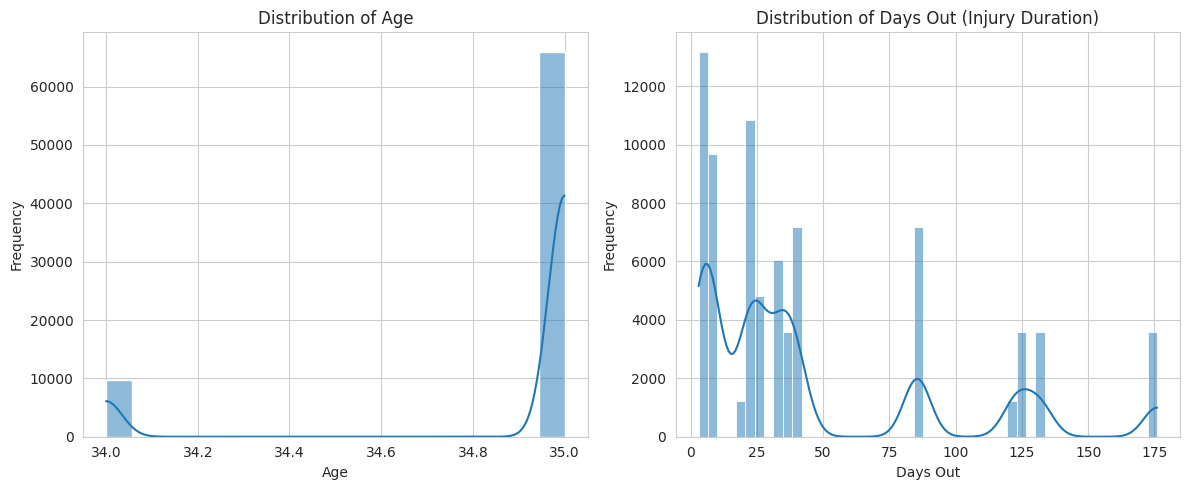

In [ ]:
print("Descriptive statistics for 'age' and 'days_out' in df_refined_features:")
print(df_refined_features[['age', 'days_out']].describe())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_refined_features['age'].dropna(), kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_refined_features['days_out'].dropna(), kde=True)
plt.title('Distribution of Days Out (Injury Duration)')
plt.xlabel('Days Out')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Implement Advanced Feature Selection




In [ ]:
print("Descriptive statistics for key features in df_refined_features:")
selected_features = ['age', 'days_out', 'G_A_per_match', 'Injury_Impact_Index', 'Value_Efficiency_Ratio']
print(df_refined_features[selected_features].describe())

Descriptive statistics for key features in df_refined_features:
                age      days_out  G_A_per_match  Injury_Impact_Index  \
count  75731.000000  75731.000000   71303.000000         7.573100e+04   
mean      34.871545     45.667455       1.506873         1.024867e+06   
std        0.334598     47.964247       3.930973         1.217604e+06   
min       34.000000      3.000000       0.000000         1.702467e+04   
25%       35.000000      9.000000       0.000000         9.145191e+04   
50%       35.000000     26.000000       0.041667         1.408258e+05   
75%       35.000000     85.000000       0.625000         2.224635e+06   
max       35.000000    176.000000      25.999974         3.623301e+06   

       Value_Efficiency_Ratio  
count            7.130300e+04  
mean             3.075781e+11  
std              3.474186e+11  
min              2.692310e+04  
25%              1.119998e+06  
50%              1.679960e+07  
75%              7.000000e+11  
max              7.000

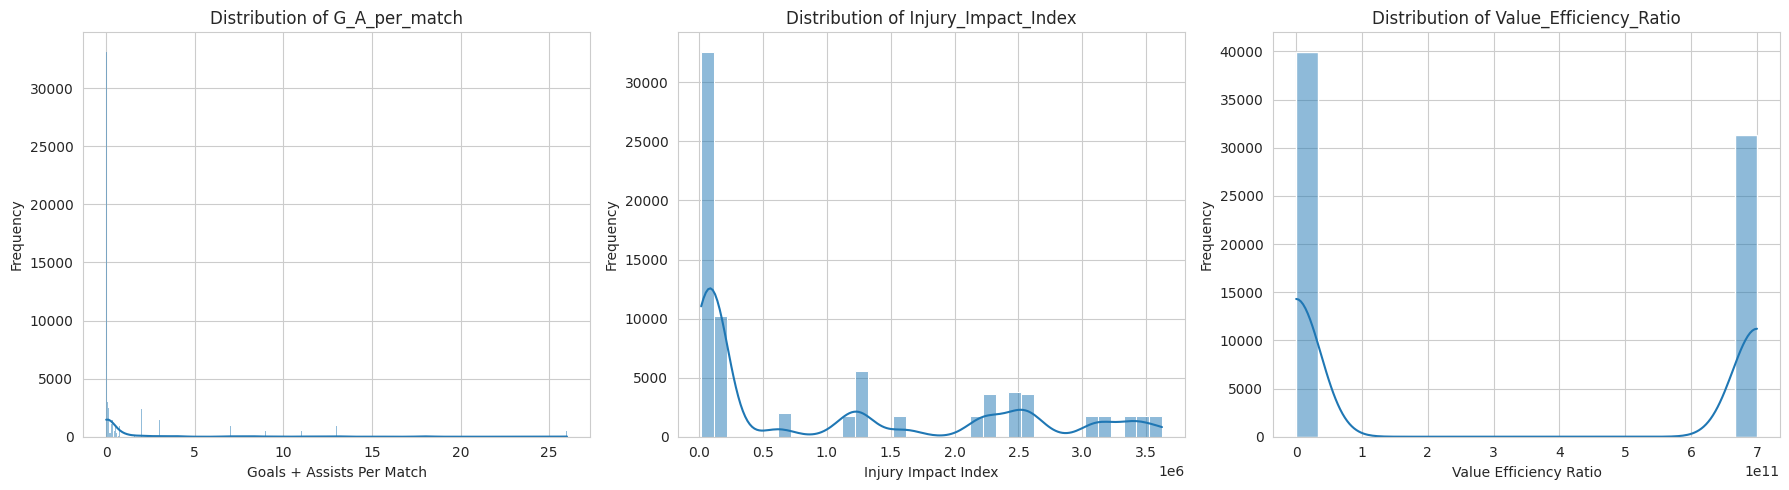

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_refined_features['G_A_per_match'].dropna(), kde=True)
plt.title('Distribution of G_A_per_match')
plt.xlabel('Goals + Assists Per Match')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(df_refined_features['Injury_Impact_Index'].dropna(), kde=True)
plt.title('Distribution of Injury_Impact_Index')
plt.xlabel('Injury Impact Index')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(df_refined_features['Value_Efficiency_Ratio'].dropna(), kde=True)
plt.title('Distribution of Value_Efficiency_Ratio')
plt.xlabel('Value Efficiency Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

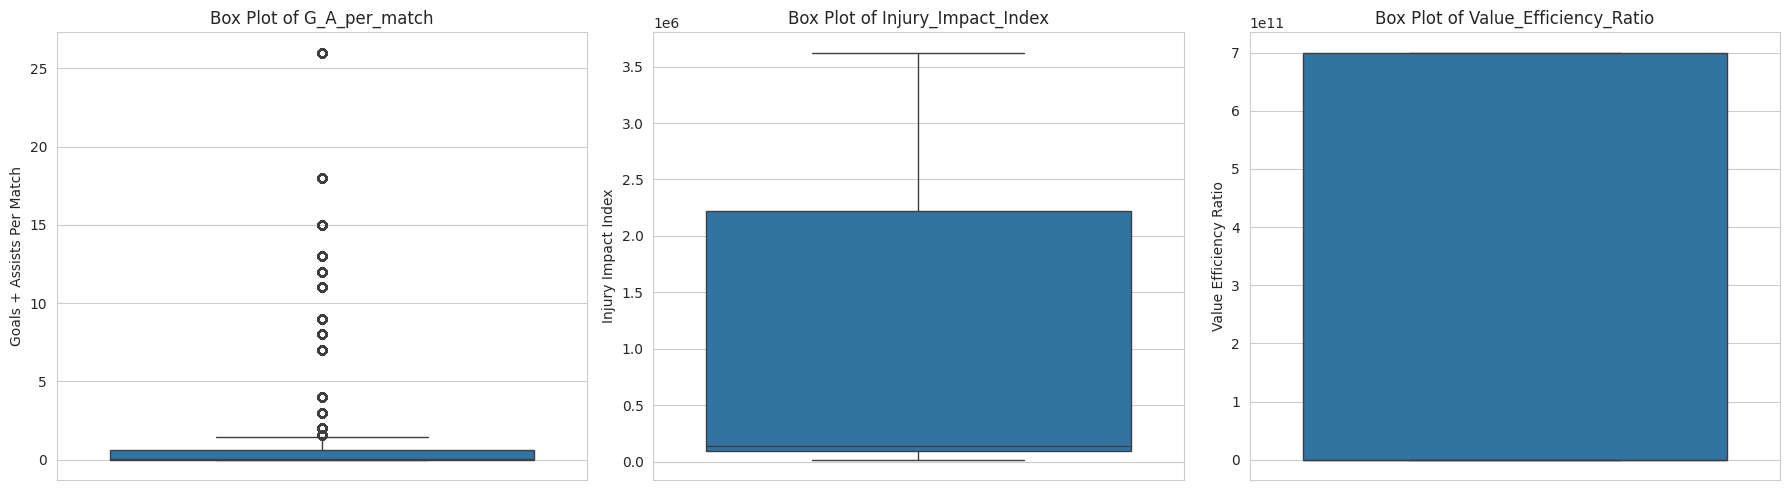

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df_refined_features['G_A_per_match'].dropna())
plt.title('Box Plot of G_A_per_match')
plt.ylabel('Goals + Assists Per Match')

plt.subplot(1, 3, 2)
sns.boxplot(y=df_refined_features['Injury_Impact_Index'].dropna())
plt.title('Box Plot of Injury_Impact_Index')
plt.ylabel('Injury Impact Index')

plt.subplot(1, 3, 3)
sns.boxplot(y=df_refined_features['Value_Efficiency_Ratio'].dropna())
plt.title('Box Plot of Value_Efficiency_Ratio')
plt.ylabel('Value Efficiency Ratio')

plt.tight_layout()
plt.show()

In [ ]:
columns_to_cap_derived = ['G_A_per_match', 'Injury_Impact_Index', 'Value_Efficiency_Ratio']

for col in columns_to_cap_derived:
    # Drop NA values for quantile calculation to avoid errors
    temp_series = df_refined_features[col].dropna()

    if not temp_series.empty:
        Q1 = temp_series.quantile(0.25)
        Q3 = temp_series.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap the outliers in the original DataFrame
        df_refined_features[col] = np.where(df_refined_features[col] < lower_bound, lower_bound, df_refined_features[col])
        df_refined_features[col] = np.where(df_refined_features[col] > upper_bound, upper_bound, df_refined_features[col])
    else:
        print(f"Warning: Column '{col}' has no non-NA values for outlier detection.")

print("Outliers in derived features capped successfully using IQR method.")
print("Descriptive statistics after capping derived features:")
print(df_refined_features[columns_to_cap_derived].describe())

Outliers in derived features capped successfully using IQR method.
Descriptive statistics after capping derived features:
       G_A_per_match  Injury_Impact_Index  Value_Efficiency_Ratio
count   71303.000000         7.573100e+04            7.130300e+04
mean        0.396487         1.024867e+06            3.075781e+11
std         0.593796         1.217604e+06            3.474186e+11
min         0.000000         1.702467e+04            2.692310e+04
25%         0.000000         9.145191e+04            1.119998e+06
50%         0.041667         1.408258e+05            1.679960e+07
75%         0.625000         2.224635e+06            7.000000e+11
max         1.562500         3.623301e+06            7.000000e+11


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Ensure tweets_df is loaded (it was loaded earlier in the notebook)
# We need to drop NA values from the 'text' column before vectorization
tweets_df_clean = tweets_df.dropna(subset=['text']).copy()

# Initialize CountVectorizer
# Using a small max_features to keep the number of new features manageable for demonstration
# and to avoid excessively large sparse matrices which can be memory intensive.
vectorizer = CountVectorizer(max_features=1000, stop_words='english')

# Fit and transform the tweet text
sentiment_features = vectorizer.fit_transform(tweets_df_clean['text'])

# Create a DataFrame from the sentiment features
sentiment_features_df = pd.DataFrame(sentiment_features.toarray(), columns=vectorizer.get_feature_names_out())

# Re-attach player_id to the sentiment features DataFrame for aggregation
sentiment_features_df['player_name_upper'] = tweets_df_clean['player_name_upper'].reset_index(drop=True)

# Aggregate the sentiment features by player_name_upper (summing word counts)
sentiment_features_agg = sentiment_features_df.groupby('player_name_upper').sum()

print(f"Shape of aggregated sentiment features: {sentiment_features_agg.shape}")
print("First 5 rows of aggregated sentiment features:")
print(sentiment_features_agg.head())

Shape of aggregated sentiment features: (521, 1000)
First 5 rows of aggregated sentiment features:
                    10  100  11  12  15  16  18  19  20  2022  2023  21  22  \
player_name_upper                                                             
AARON CRESSWELL      5    1   0   0   0   0   1   0   0     1     4   0   0   
AARON HICKEY         3    2   1   0   0   1   0   0   6     0     6   2   0   
AARON RAMSDALE       8    2   2   6   5   0   0   1   2     9     1   2   0   
AARON WAN-BISSAKA    3    3   4   3   0   0   0   0   2     0     5   3   0   
ABDOULAYE DOUCOURÉ   9    1   6   1   0   2   1   2   0     1     1   2   4   

                    23  23afc  23arsenal  23avfc  23bhafc  23cfc  23football  \
player_name_upper                                                              
AARON CRESSWELL      0      0          0       0        0      0           0   
AARON HICKEY         0      0          0       0        0      0           0   
AARON RAMSDALE       2     

In [ ]:
import pandas as pd

# 1. Create player_name_upper in df_outlier_analysis to match sentiment_features_agg
df_outlier_analysis['player_name_upper'] = df_outlier_analysis['player_name'].str.split('(', n=1).str[0].str.strip().str.upper()

# 2. Reset index of sentiment_features_agg to make 'player_name_upper' a column
sentiment_features_agg_reset = sentiment_features_agg.reset_index()

# 3. Merge df_outlier_analysis with the new sentiment features
df_merged_with_new_sentiment = pd.merge(
    df_outlier_analysis,
    sentiment_features_agg_reset,
    on='player_name_upper',
    how='left'
)

# 4. Update columns_for_refined_df with new sentiment feature names
new_sentiment_columns = vectorizer.get_feature_names_out()
updated_columns_for_refined_df = columns_for_refined_df + list(new_sentiment_columns)

# Ensure all columns exist before creating df_refined_features, handling potential missingness from the merge
# Fill NaN values in new sentiment columns with 0 after merge, as they represent word counts
for col in new_sentiment_columns:
    if col not in df_merged_with_new_sentiment.columns:
        df_merged_with_new_sentiment[col] = 0.0
    df_merged_with_new_sentiment[col] = df_merged_with_new_sentiment[col].fillna(0)


# Re-create df_refined_features with the merged data and new sentiment columns
df_refined_features = df_merged_with_new_sentiment[updated_columns_for_refined_df].copy()

print(f"Shape of df_refined_features after integrating new sentiment features: {df_refined_features.shape}")
print("Head of df_refined_features with new sentiment features:")
print(df_refined_features.head())

/tmp/ipython-input-1190477182.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged_with_new_sentiment[col] = 0.0
/tmp/ipython-input-1190477182.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged_with_new_sentiment[col] = 0.0


Shape of df_refined_features after integrating new sentiment features: (75731, 1020)
Head of df_refined_features with new sentiment features:
   age   value_x  matches  goals_x  assists  minutes_played  days_out  \
0  0.0  700000.0        2      NaN      0.0           360.0      34.0   
1  0.0  700000.0        4      NaN      0.0           360.0      34.0   
2  0.0  700000.0        1      NaN      0.0           360.0      34.0   
3  0.0  700000.0        2      NaN      0.0          2610.0      34.0   
4  0.0  700000.0        4      NaN      0.0          2610.0      34.0   

   vader_polarity  tb_polarity  goals_per_90_min  assists_per_90_min  \
0        0.165895     0.053446               NaN                 0.0   
1        0.165895     0.053446               NaN                 0.0   
2        0.165895     0.053446               NaN                 0.0   
3        0.165895     0.053446               NaN                 0.0   
4        0.165895     0.053446               NaN           

In [ ]:
import pandas as pd

# 1. Create player_name_upper in df_outlier_analysis to match sentiment_features_agg
df_outlier_analysis['player_name_upper'] = df_outlier_analysis['player_name'].str.split('(', n=1).str[0].str.strip().str.upper()

# 2. Reset index of sentiment_features_agg to make 'player_name_upper' a column
sentiment_features_agg_reset = sentiment_features_agg.reset_index()

# 3. Merge df_outlier_analysis with the new sentiment features
df_merged_with_new_sentiment = pd.merge(
    df_outlier_analysis,
    sentiment_features_agg_reset,
    on='player_name_upper',
    how='left'
)

# Identify the columns that were originally part of sentiment_features_agg_reset
# excluding the merge key ('player_name_upper')
original_sentiment_columns_base = [col for col in sentiment_features_agg_reset.columns if col != 'player_name_upper']

# Now, determine their actual names in df_merged_with_new_sentiment (with potential '_y' suffixes)
actual_sentiment_cols_in_merged_df = []
for col in original_sentiment_columns_base:
    if f"{col}_y" in df_merged_with_new_sentiment.columns:
        actual_sentiment_cols_in_merged_df.append(f"{col}_y")
    elif col in df_merged_with_new_sentiment.columns:
        actual_sentiment_cols_in_merged_df.append(col)

# Fill NaN values for these identified sentiment columns (which are guaranteed to exist now)
df_merged_with_new_sentiment[actual_sentiment_cols_in_merged_df] = df_merged_with_new_sentiment[actual_sentiment_cols_in_merged_df].fillna(0)

# Construct updated_columns_for_refined_df for the final DataFrame selection.
# It needs core features from columns_for_refined_df (potentially '_x' suffixed)
# and the actual sentiment features (actual_sentiment_cols_in_merged_df).

final_selected_columns_for_df_refined = []
for col in columns_for_refined_df:
    if f"{col}_x" in df_merged_with_new_sentiment.columns:
        final_selected_columns_for_df_refined.append(f"{col}_x")
    elif col in df_merged_with_new_sentiment.columns:
        final_selected_columns_for_df_refined.append(col)

final_selected_columns_for_df_refined.extend(actual_sentiment_cols_in_merged_df)

# Remove duplicates if any (though unlikely with this construction logic)
updated_columns_for_refined_df = list(pd.unique(final_selected_columns_for_df_refined))

# Re-create df_refined_features
df_refined_features = df_merged_with_new_sentiment[updated_columns_for_refined_df].copy()

print(f"Shape of df_refined_features after integrating new sentiment features: {df_refined_features.shape}")
print("Head of df_refined_features with new sentiment features:")
print(df_refined_features.head())

/tmp/ipython-input-1371453469.py:46: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  updated_columns_for_refined_df = list(pd.unique(final_selected_columns_for_df_refined))


Shape of df_refined_features after integrating new sentiment features: (75731, 1020)
Head of df_refined_features with new sentiment features:
   age_x   value_x  matches  goals_x  assists_x  minutes_played  days_out  \
0     35  700000.0        2      NaN        0.0           360.0      34.0   
1     35  700000.0        4      NaN        0.0           360.0      34.0   
2     35  700000.0        1      NaN        0.0           360.0      34.0   
3     35  700000.0        2      NaN        0.0          2610.0      34.0   
4     35  700000.0        4      NaN        0.0          2610.0      34.0   

   vader_polarity  tb_polarity  goals_per_90_min  assists_per_90_min  \
0        0.165895     0.053446               NaN                 0.0   
1        0.165895     0.053446               NaN                 0.0   
2        0.165895     0.053446               NaN                 0.0   
3        0.165895     0.053446               NaN                 0.0   
4        0.165895     0.053446     

In [ ]:
print("\n[STEP 4/5] Re-applying Data Preprocessing Pipeline with new sentiment features...")

# Ensure all specified numerical features exist in df_refined_features, handling potential '_x' suffixes
# Original numerical features that might have an '_x' suffix after merging
original_numerical_cols = [
    'age', 'value_x', 'matches', 'goals_x', 'assists', 'minutes_played',
    'days_out', 'vader_polarity', 'tb_polarity', 'goals_per_90_min',
    'assists_per_90_min', 'G_A_per_match', 'normalized_sentiment',
    'Injury_Impact_Index', 'Value_Efficiency_Ratio', 'log_days_out'
]

# Adjust original numerical features for potential '_x' suffix if they clashed during merge
numerical_features_updated = []
for col in original_numerical_cols:
    if f'{col}_x' in df_refined_features.columns:
        numerical_features_updated.append(f'{col}_x')
    elif col in df_refined_features.columns:
        numerical_features_updated.append(col)

# Categorical features that might have an '_x' suffix
original_categorical_cols = ['citizenship', 'position', 'current_club_name', 'injury_reason']
categorical_features_updated = []
for col in original_categorical_cols:
    if f'{col}_x' in df_refined_features.columns:
        categorical_features_updated.append(f'{col}_x')
    elif col in df_refined_features.columns:
        categorical_features_updated.append(col)


# Add CountVectorizer features to numerical features
# Get all columns that are not in the updated numerical or categorical lists yet
existing_cols = set(numerical_features_updated + categorical_features_updated)
count_vectorizer_features = [col for col in df_refined_features.columns if col not in existing_cols]
numerical_features_updated.extend(count_vectorizer_features)

# Ensure there are no duplicate features in the lists
numerical_features_updated = list(set(numerical_features_updated))
categorical_features_updated = list(set(categorical_features_updated))

# Re-define the ColumnTransformer with updated feature lists
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_updated),
        ('cat', categorical_transformer, categorical_features_updated)
    ],
    remainder='drop' # Drop any columns not specified
)

# Drop columns that are not part of features (e.g. player_name_upper, if it were not dropped already)
X_refined = df_refined_features.drop(columns=['player_name_upper'], errors='ignore')

# Apply the Pipeline to the refined features
X_processed_final = preprocessor.fit_transform(X_refined)

# Get feature names after one-hot encoding
feature_names_final = numerical_features_updated + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features_updated))

# Create the final processed DataFrame
processed_df_final = pd.DataFrame(X_processed_final, columns=feature_names_final)

# Save the final cleaned/processed data
processed_df_final.to_csv("cleaned_processed_data_final.csv", index=False)
print("✅ Final Processed Data (including new sentiment features) saved to 'cleaned_processed_data_final.csv'.")
print(f"\nProcessed Data Head (Scaled, first 10 columns):\n{processed_df_final.iloc[:, :10].head()}")
print(f"Processed Data Shape: {processed_df_final.shape}")


[STEP 4/5] Re-applying Data Preprocessing Pipeline with new sentiment features...
✅ Final Processed Data (including new sentiment features) saved to 'cleaned_processed_data_final.csv'.

Processed Data Head (Scaled, first 10 columns):
   jorginho       bro  casemiro   person       cup      wait       lol  \
0  -0.38391 -0.619407 -2.277204 -0.38391 -0.735458 -2.217854 -2.257957   
1  -0.38391 -0.619407 -2.277204 -0.38391 -0.735458 -2.217854 -2.257957   
2  -0.38391 -0.619407 -2.277204 -0.38391 -0.735458 -2.217854 -2.257957   
3  -0.38391 -0.619407 -2.277204 -0.38391 -0.735458 -2.217854 -2.257957   
4  -0.38391 -0.619407 -2.277204 -0.38391 -0.735458 -2.217854 -2.257957   

   understand      work  morgan  
0   -0.462643 -2.366994     0.0  
1   -0.462643 -2.366994     0.0  
2   -0.462643 -2.366994     0.0  
3   -0.462643 -2.366994     0.0  
4   -0.462643 -2.366994     0.0  
Processed Data Shape: (75731, 1043)
